In [283]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

scaler = MinMaxScaler()
data = pd.read_csv("./housing_prices.csv")

In [205]:
# Check how many unique values each column has
for col in data.columns:
    unique_count = data[col].nunique()
    print(f"Column '{col}' has {unique_count} unique values.")
# Get minimum and maximum value for RAD.
print(" \n Min value in RAD is " + str(min(data['RAD'])) + " and max is " + str(max(data['RAD'])) + ".")

Column 'CRIM' has 509 unique values.
Column 'ZN' has 26 unique values.
Column 'INDUS' has 79 unique values.
Column 'CHAS' has 2 unique values.
Column 'NOX' has 82 unique values.
Column 'RM' has 444 unique values.
Column 'AGE' has 357 unique values.
Column 'DIS' has 416 unique values.
Column 'RAD' has 9 unique values.
Column 'TAX' has 67 unique values.
Column 'PTRATIO' has 47 unique values.
Column 'B' has 360 unique values.
Column 'LSTAT' has 460 unique values.
Column 'MEDV' has 231 unique values.
 
 Min value in RAD is 1 and max is 24.


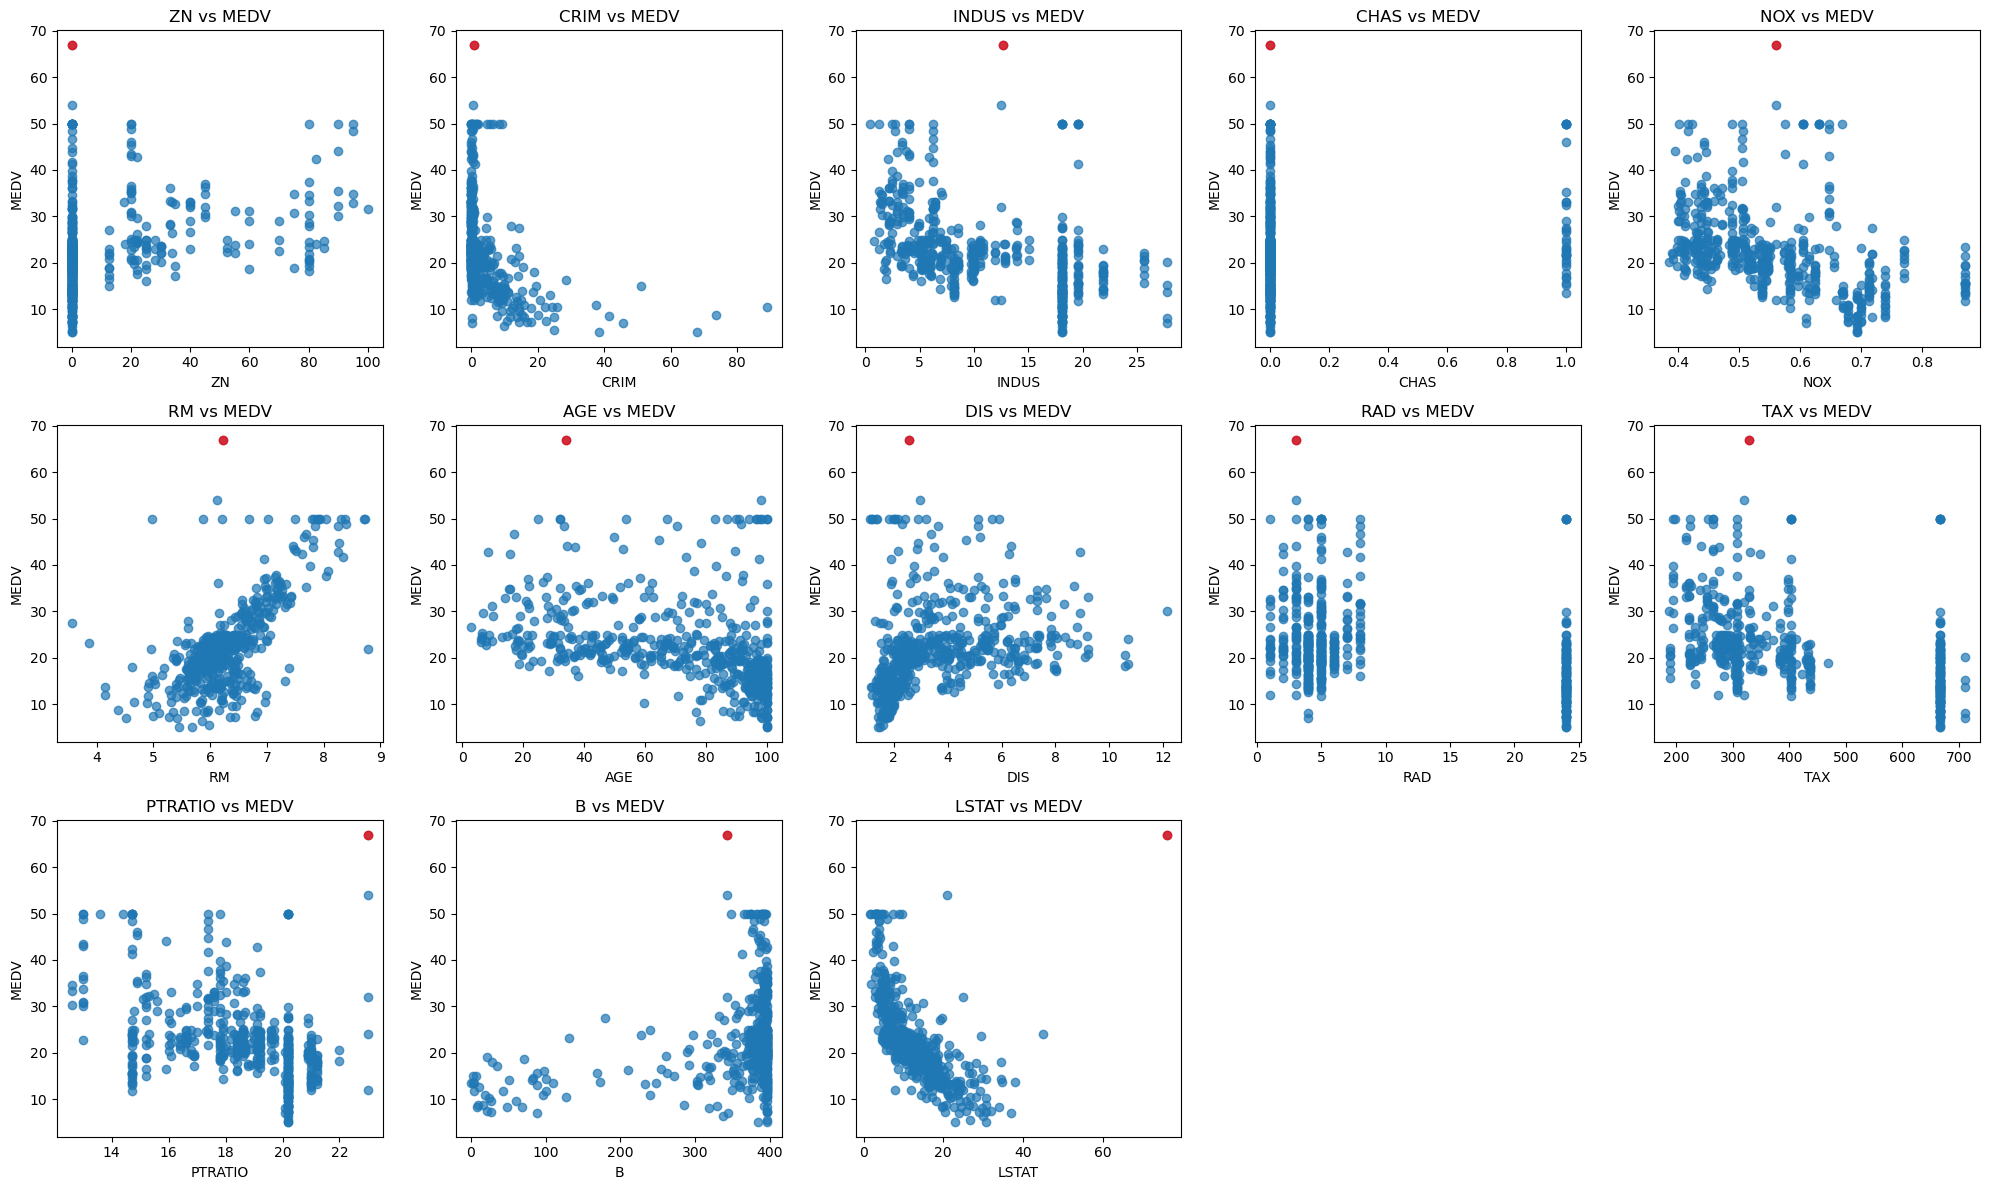

In [206]:
# Simple XY scatter plots between label and different features
feature_candidates = ['ZN', 'CRIM', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(feature_candidates)
num_rows = 3
num_cols = (num_features + num_rows - 1) // num_rows
plt.figure(figsize=(num_cols * 4, num_rows * 4))
# Pick an outlier manually
a = data[data['LSTAT'] > 50]

for i, feature in enumerate(feature_candidates):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(data[feature], data['MEDV'], alpha=0.7)
    plt.scatter(a[feature], a['MEDV'], color='red', label='LSTAT > 50', alpha=0.7)
    
    plt.xlabel(feature)
    plt.ylabel('MEDV')
    plt.title(f'{feature} vs MEDV')
    plt.gca() 
plt.tight_layout()
plt.show()

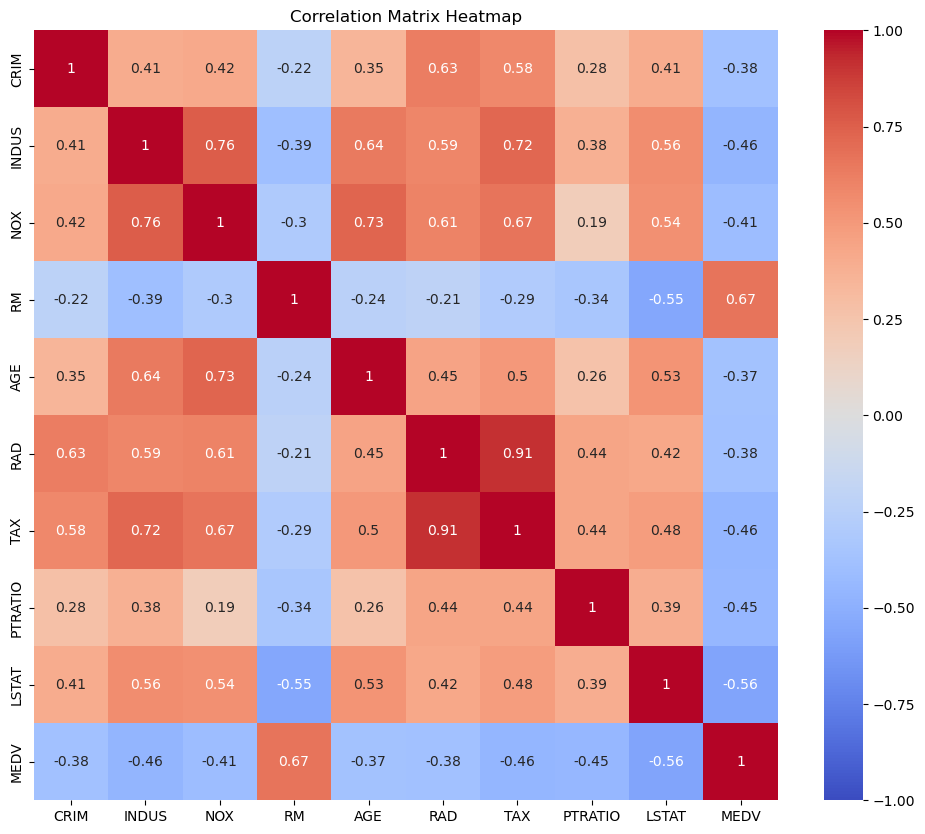

In [207]:
# Draw a correlation matrix (columns compared to other columns)
# Note especially the last column with comparisons to the label column
corr_matrix = data.corr()
medv_corr = corr_matrix['MEDV']

# Filter out columns with correlation between -0.35 and 0.35 with 'MEDV'
columns_to_keep = medv_corr[~medv_corr.abs().between(-0.35, 0.35)].index
filtered_data = data[columns_to_keep]

filtered_corr_matrix = filtered_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [208]:
# See rows which have missing values.
rows_with_nan = filtered_data[filtered_data.isnull().any(axis=1)]
print(rows_with_nan)
filtered_data = filtered_data.fillna(filtered_data.median())
filtered_data['RM'].median()

        CRIM  INDUS    NOX  RM   AGE  RAD  TAX  PTRATIO  LSTAT  MEDV
10   0.22489   7.87  0.524 NaN  94.3    5  311     15.2  20.45  15.0
35   0.06417   5.96  0.499 NaN  68.2    5  279     19.2   9.68  18.9
63   0.12650   5.13  0.453 NaN  43.4    8  284     19.7   9.50  25.0
96   0.11504   2.89  0.445 NaN  69.6    2  276     18.0  11.34  21.4
135  0.55778  21.89  0.624 NaN  98.2    4  437     21.2  16.96  18.1


6.209

## Split into training, testing and validation sets

In [293]:
# Split into different training, testing and validation sets
train_size = 0.67
test_size = 1-0.67
cross_size = 0.5
X = filtered_data.drop(columns=['MEDV'], axis=1)
y = filtered_data['MEDV']

X_train, X_splitted, y_train, y_splitted = train_test_split(X, y, test_size=test_size, train_size=train_size, shuffle=True)
X_test, X_cross, y_test, y_cross = train_test_split(X_splitted, y_splitted, test_size = cross_size, shuffle=False)
print("Size of training set: " + str(len(X_train)))
print("Size of testing set: " + str(len(y_test)))
print("Size of testing set: " + str(len(y_cross)))

Size of training set: 342
Size of testing set: 84
Size of testing set: 85


## Perform Lasso Linear Regression

Mean squared error with the best regularization parameter: 33.20991671131628
Best regularization parameter value: 1.0
Lasso loss function error with the best regularization parameter: 0.5543600209129034


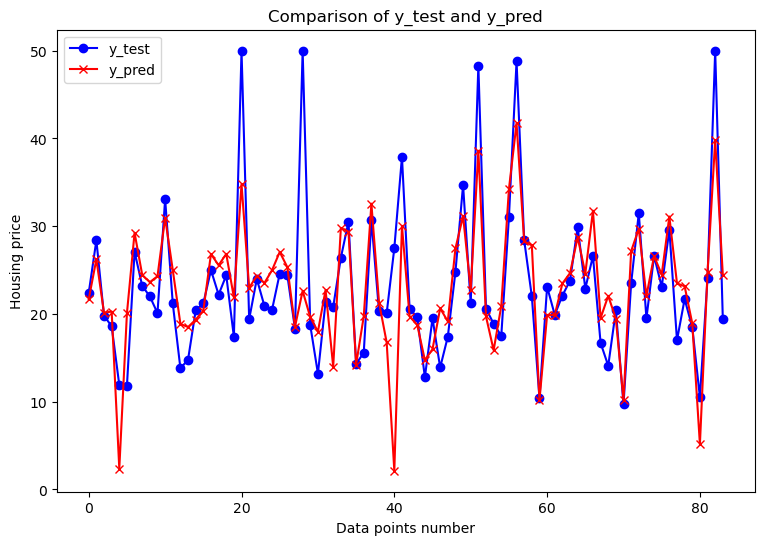

In [294]:
clf = Lasso()
parameter_options = {'alpha': np.logspace(-4, 0, 50)}  # parameter options from 10^(-4) to 1
# Search for the best parameter value with the help of mean squared error for each iteration
grid_search = GridSearchCV(clf, parameter_options, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Note that we use the cross-validation set to search for the best alpha value
grid_search.fit(X_cross, y_cross)
best_alpha = grid_search.best_params_['alpha']

# Create the model with the previously gotten best alpha value
final_clf = Lasso(alpha=best_alpha)
# Fit the training set
final_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
y_test = np.array(y_test)
mse = mean_squared_error(y_test, y_pred)
lasso_loss = best_clf.score(X_test, y_test)
print("Mean squared error with the best regularization parameter: " + str(mse))
print("Best regularization parameter value: " + str(best_alpha))
print("Lasso loss function error with the best regularization parameter: " + str(lasso_loss))
# Visualize the results
plt.figure(figsize=(9, 6))
plt.plot(y_test, label='y_test', marker='o', color='b')
plt.plot(y_pred, label='y_pred', marker='x', color='r')
plt.title('Comparison of y_test and y_pred')
plt.xlabel('Data points number')
plt.ylabel('Housing price')
plt.legend()
plt.show()

## Perform random forest regressor

Mean squared error of RandomForestRegressor: 10.657511869047616


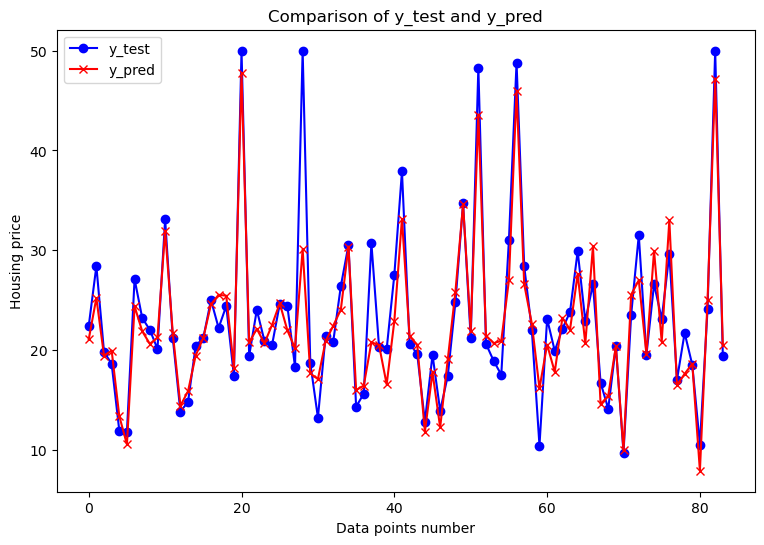

In [303]:
rfr = RandomForestRegressor(random_state=0, criterion='squared_error')
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rfr)
print("Mean squared error of RandomForestRegressor: " + str(mse))

plt.figure(figsize=(9, 6))
plt.plot(y_test, label='y_test', marker='o', color='b')
plt.plot(y_pred_rfr, label='y_pred', marker='x', color='r')
plt.title('Comparison of y_test and y_pred')
plt.xlabel('Data points number')
plt.ylabel('Housing price')
plt.legend()
plt.show()